## 1 Install and Import Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/artificial_intelligence/dataset1.zip -d /content/

In [ ]:
# install wandb
!pip install wandb -qU

     |████████████████████████████████| 1.9 MB 38.7 MB/s 
     |████████████████████████████████| 182 kB 58.8 MB/s 
     |████████████████████████████████| 168 kB 60.8 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 168 kB 81.5 MB/s 
     |████████████████████████████████| 166 kB 79.6 MB/s 
     |████████████████████████████████| 166 kB 75.2 MB/s 
     |████████████████████████████████| 162 kB 79.7 MB/s 
     |████████████████████████████████| 162 kB 83.3 MB/s 
     |████████████████████████████████| 158 kB 74.9 MB/s 
     |████████████████████████████████| 157 kB 79.9 MB/s 
     |████████████████████████████████| 157 kB 78.5 MB/s 
     |████████████████████████████████| 157 kB 75.4 MB/s 
     |████████████████████████████████| 157 kB 82.5 MB/s 
     |████████████████████████████████| 157 kB 65.0 MB/s 
     |████████████████████████████████| 157 kB 69.8 MB/s 
     |████████████████████████████████| 157 kB 16.6 MB/s 
     |██████████

In [ ]:
# import the necessary packages
from imutils import paths
import logging
import os
import cv2
import numpy as np
import joblib
import tensorflow as tf
import wandb
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

In [ ]:
args = {
	"dataset": "Bag Classes",
  "project_name": "bag_classifier",
  "artifact_name": "bag_raw_data"
}

In [ ]:
run = wandb.init(entity="thaisaraujom",project=args["project_name"], job_type="fetch_data")

# create an artifact for all the raw data
raw_data = wandb.Artifact(args["artifact_name"], type="raw_data")

# grab the list of images that we'll be describing
logger.info("[INFO] loading images...")
imagePaths = list(paths.list_images(args["dataset"]))

# append all images to the artifact
for img in imagePaths:
  label = img.split(os.path.sep)
  raw_data.add_file(img, name=os.path.join(label[-2],label[-1]))

# save artifact to W&B
run.log_artifact(raw_data)
run.finish()

01-12-2022 22:15:39 [INFO] loading images...


## 2.2 Fetch and Data Segregation

In [ ]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "bag_classifier",
  "artifact_name": "bag_raw_data:latest",
}

In [ ]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="thaisaraujom",project=args["project_name"], job_type="preprocessing")

# download the raw data from W&B
raw_data = run.use_artifact(args["artifact_name"])
data_dir = raw_data.download()
logger.info("Path: {}".format(data_dir))

wandb: Downloading large artifact bag_raw_data:latest, 221.99MB. 15000 files... 
wandb:   15000 of 15000 files downloaded.  
Done. 0:0:6.2
01-12-2022 22:23:42 Path: ./artifacts/bag_raw_data:v1


In [ ]:
run.finish()

In [ ]:
data_dir

'./artifacts/bag_raw_data:v1'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

raw_wb = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                     shuffle=True,
                                                     batch_size=BATCH_SIZE,
                                                     image_size=IMG_SIZE,
                                                     label_mode='categorical')

Found 15000 files belonging to 3 classes.


In [ ]:
type(raw_wb)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [ ]:
# 80% train, 20% validation and test
all_batches = tf.data.experimental.cardinality(raw_wb)
valtest_dataset = raw_wb.take(all_batches // 5)
train_dataset = raw_wb.skip(all_batches // 5)

valtest_batches = tf.data.experimental.cardinality(valtest_dataset)
test_dataset = valtest_dataset.take(valtest_batches // 5)
validation_dataset = valtest_dataset.skip(valtest_batches // 5)

In [ ]:
print('Number of raw batches: %d' % tf.data.experimental.cardinality(raw_wb))
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of raw batches: 469
Number of train batches: 376
Number of validation batches: 75
Number of test batches: 18


In [ ]:
raw_wb

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

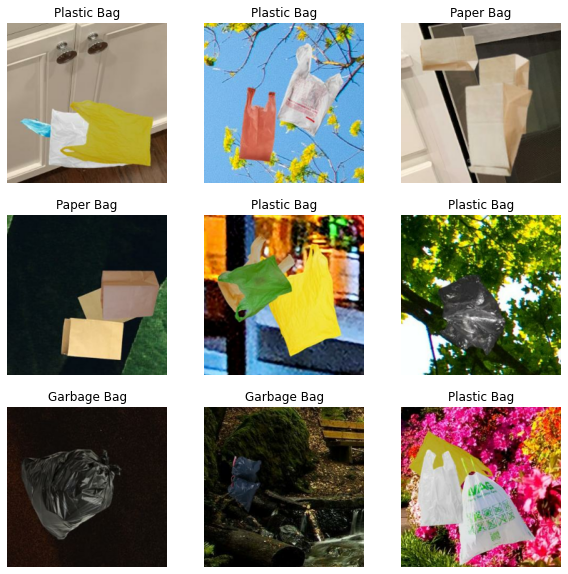

In [ ]:
class_names = raw_wb.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(labels[i])])
    plt.axis("off")

In [ ]:
len(class_names)

3

## 2.3 Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## 2.4 Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting. You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
from pathlib import Path
import imghdr

image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

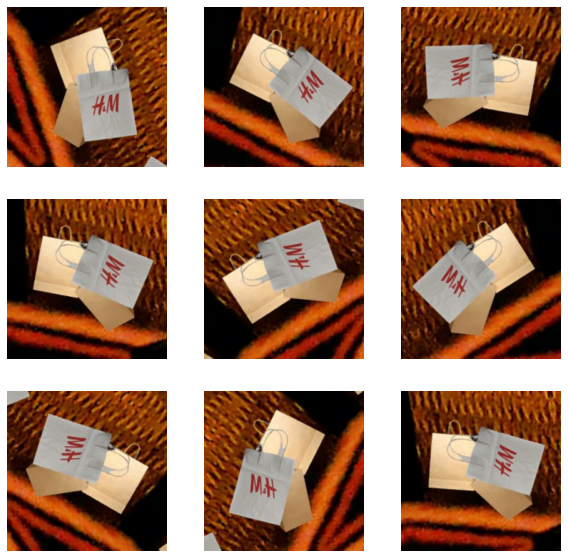

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## 2.5 Create the base model from the pre-trained convnets


In [ ]:
# Create the base model from the pre-trained model VGG16
IMG_SHAPE = IMG_SIZE + (3,)
model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

This feature extractor converts each 224x224x3 image into a 7x7x512 block of features. Let's see what it does to an example batch of images:




In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 512)


## 2.6 Feature extractor

In [ ]:
args = {
  "project_name": "bag_classifier"
}

# open the W&B project created in the Fetch step
run = wandb.init(entity="thaisaraujom",
                 project=args["project_name"], 
                 job_type="feature_extraction")

In [ ]:
model.trainable = False

## 2.7 Add a classification head

To generate predictions from the block of features, average over the spatial 7x7 spatial locations, using a [tf.keras.layers.GlobalAveragePooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer to convert the features to a single 512-element vector per image.




In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


Apply a [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer to convert these features into a single prediction per image.

In [ ]:
prediction_layer = tf.keras.layers.Dense(3,"softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


Build a model by chaining together the data augmentation, [tf.keras.applications.vgg16.preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input), model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional).

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
x = model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

## 2.8 Compile the model

Compile the model before training it.

In [ ]:
# initialize the optimizer and model
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss="categorical_crossentropy",
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

The 14.714.688 million parameters in VGG16 are frozen, but there are 1,539 thousand trainable parameters in the Dense layer. These are divided between two [tf.Variable](https://www.tensorflow.org/api_docs/python/tf/Variable) objects, the weights and biases.




In [ ]:
len(model.trainable_variables)

2

## 2.9 Train and Evalute the model

In [ ]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=20,
                    verbose=1)

Epoch 1/20
376/376 [==============================] - 89s 228ms/step - loss: 2.3684 - accuracy: 0.4702 - val_loss: 0.9183 - val_accuracy: 0.7254
Epoch 2/20
376/376 [==============================] - 87s 223ms/step - loss: 1.0268 - accuracy: 0.7093 - val_loss: 0.4934 - val_accuracy: 0.8404
Epoch 3/20
376/376 [==============================] - 87s 223ms/step - loss: 0.7167 - accuracy: 0.7979 - val_loss: 0.3550 - val_accuracy: 0.8871
Epoch 4/20
376/376 [==============================] - 88s 225ms/step - loss: 0.5399 - accuracy: 0.8371 - val_loss: 0.2525 - val_accuracy: 0.9154
Epoch 5/20
376/376 [==============================] - 87s 223ms/step - loss: 0.4372 - accuracy: 0.8668 - val_loss: 0.2090 - val_accuracy: 0.9279
Epoch 6/20
376/376 [==============================] - 88s 226ms/step - loss: 0.3771 - accuracy: 0.8816 - val_loss: 0.1772 - val_accuracy: 0.9425
Epoch 7/20
376/376 [==============================] - 87s 222ms/step - loss: 0.3276 - accuracy: 0.8947 - val_loss: 0.1457 - val_ac

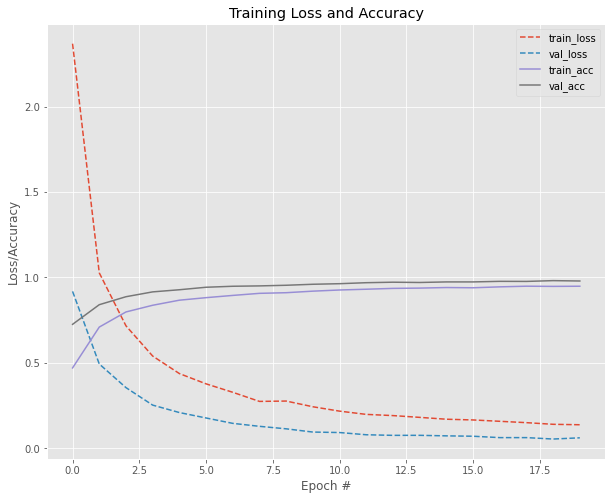

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 20), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 20), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

Note the dataset is a generator (``tensorflow.python.data.ops.dataset_ops.PrefetchDataset``). Thus, each time you call the dataset object a new (and different) sequence of images will be returned. This is very important to guarantee the same sequence is used in ``model.predict(test_dataset)`` and ``true_labels``. 

In [ ]:
type(test_dataset)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [ ]:
y = np.concatenate([y for x, y in test_dataset], axis=0)
y2 = np.concatenate([y for x, y in test_dataset], axis=0)

In [ ]:
# as previous mentioned, y is different of y2
# because test_dataset is a generator
assert y == y2

ValueError: ignored

A possible solution is to extract a snapshot of ``test_dataset``.

In [ ]:
images, labels = tuple(zip(*test_dataset))
images = np.concatenate(images,axis=0)
labels = np.concatenate(labels,axis=0)

In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(images, batch_size=32)
print(classification_report(tf.argmax(labels, axis=1),
                            tf.argmax(predictions, axis=1),
                            target_names=class_names))

[INFO] evaluating network...
18/18 [==============================] - 3s 158ms/step
              precision    recall  f1-score   support

 Garbage Bag       0.98      0.99      0.99       190
   Paper Bag       0.97      0.97      0.97       191
 Plastic Bag       0.97      0.97      0.97       195

    accuracy                           0.98       576
   macro avg       0.98      0.98      0.98       576
weighted avg       0.98      0.98      0.98       576



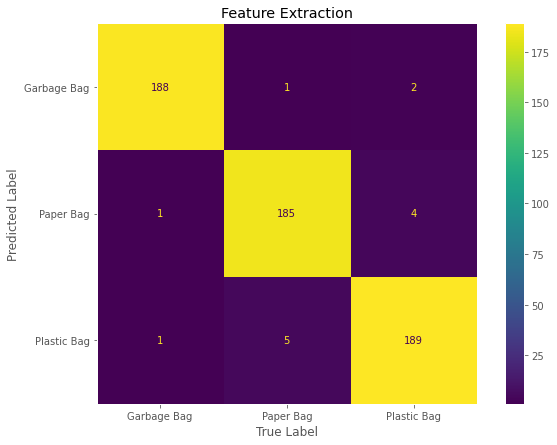

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(10,7))
ConfusionMatrixDisplay(confusion_matrix(tf.argmax(predictions, axis=1),
                                        tf.argmax(labels, axis=1)),
                       display_labels=class_names).plot(values_format=".0f",ax=ax)
ax.set_title("Feature Extraction")
ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

01-12-2022 23:07:23 Uploading figures


In [ ]:
# Evaluation Metrics
logger.info("Validation Evaluation metrics")
fbeta = fbeta_score(labels.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')
precision = precision_score(labels.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
recall = recall_score(labels.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')
acc = accuracy_score(labels.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Validation Accuracy: {}".format(acc))
logger.info("Validation Precision: {}".format(precision))
logger.info("Validation Recall: {}".format(recall))
logger.info("Validation F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta
# number of parameters
run.summary["Count_Params"] = model.count_params()

01-12-2022 23:07:24 Validation Evaluation metrics
01-12-2022 23:07:24 Validation Accuracy: 0.9756944444444444
01-12-2022 23:07:24 Validation Precision: 0.9756760260708491
01-12-2022 23:07:24 Validation Recall: 0.9756944444444444
01-12-2022 23:07:24 Validation F1: 0.9756807742782152


In [ ]:
run.finish()

Acc,0.97569
Count_Params,14716227
F1,0.97568
Precision,0.97568
Recall,0.97569

















































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































# 3 - Fine-tuning networks

## 3.1 Transfer Learning and Fine-tuning

## 3.2 Indexes and Layers

In [ ]:
args = {
  "project_name": "bag_classifier"
}

# open the W&B project created in the Fetch step
run = wandb.init(entity="thaisaraujom",
                 project=args["project_name"], 
                 job_type="fine_tuning")

In [ ]:
# import the necessary packages
from tensorflow.keras.applications import VGG16

# whether or not to include top of CNN
include_top = 0

# load the VGG16 network
print("[INFO] loading network...")
model = VGG16(weights="imagenet", include_top= include_top > 0)
print("[INFO] showing layers...")

# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] loading network...
[INFO] showing layers...
[INFO] 0	InputLayer
[INFO] 1	Conv2D
[INFO] 2	Conv2D
[INFO] 3	MaxPooling2D
[INFO] 4	Conv2D
[INFO] 5	Conv2D
[INFO] 6	MaxPooling2D
[INFO] 7	Conv2D
[INFO] 8	Conv2D
[INFO] 9	Conv2D
[INFO] 10	MaxPooling2D
[INFO] 11	Conv2D
[INFO] 12	Conv2D
[INFO] 13	Conv2D
[INFO] 14	MaxPooling2D
[INFO] 15	Conv2D
[INFO] 16	Conv2D
[INFO] 17	Conv2D
[INFO] 18	MaxPooling2D


Before we can replace the head of a pre-trained CNN, we need something to replace it with – therefore, we need to define our own fully-connected head of the network.

In [ ]:
# import the necessary packages
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

# a fully connect network
class FCHeadNet:
	@staticmethod
	def build(baseModel, classes, neurons):
		# initialize the head model that will be placed on top of
		# the base, then add a FC layer
		headModel = baseModel.output # output
		headModel = Flatten(name="flatten")(headModel)
		headModel = Dense(neurons, activation="relu")(headModel)
		headModel = Dropout(0.5)(headModel)

		# add a softmax layer
		headModel = Dense(classes, activation="softmax")(headModel)

		# return the model
		return headModel

## 3.3 All in one

### First Stage

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD

In [ ]:
# Create the base model from the pre-trained model VGG16
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
outputs = base_model(x, training=False)
base_model = tf.keras.Model(inputs, outputs)

In [ ]:
base_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
Total params: 14,714,688
Trainable params: 14,714,688
Non-t

In [ ]:
# initialize the new head of the network, a set of FC layers
# followed by a softmax classifier
headModel = FCHeadNet.build(base_model, len(class_names), 256)

In [ ]:
# place the head FC model on top of the base model -- this will
# become the actual model we will train
model = Model(inputs=base_model.input, outputs=headModel)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0   

In [ ]:
# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Sequential
[INFO] 2	SlicingOpLambda
[INFO] 3	TFOpLambda
[INFO] 4	Functional
[INFO] 5	Flatten
[INFO] 6	Dense
[INFO] 7	Dropout
[INFO] 8	Dense


In [ ]:
# loop over all layers in the base model and freeze them so they
# will *not* be updated during the training process
for layer in model.layers[4].layers:
	layer.trainable = False

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0   

In [ ]:
# RMSprop is frequently used in situations where we need to quickly obtain
# reasonable performance (as is the case when we are trying to “warm up” a set of FC layers).
opt = RMSprop(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

In [ ]:
# train the head of the network for a few epochs (all other
# layers are frozen) -- this will allow the new FC layers to
# start to become initialized with actual "learned" values
# versus pure random
print("[INFO] training head...")
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=3,
                    verbose=1)

[INFO] training head...
Epoch 1/3
376/376 [==============================] - 90s 228ms/step - loss: 0.9651 - accuracy: 0.8948 - val_loss: 0.1823 - val_accuracy: 0.9679
Epoch 2/3
376/376 [==============================] - 89s 228ms/step - loss: 0.2996 - accuracy: 0.9528 - val_loss: 0.1225 - val_accuracy: 0.9796
Epoch 3/3
376/376 [==============================] - 88s 225ms/step - loss: 0.2588 - accuracy: 0.9601 - val_loss: 0.1312 - val_accuracy: 0.9808


### Second Stage

In [ ]:
# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Sequential
[INFO] 2	SlicingOpLambda
[INFO] 3	TFOpLambda
[INFO] 4	Functional
[INFO] 5	Flatten
[INFO] 6	Dense
[INFO] 7	Dropout
[INFO] 8	Dense


In [ ]:
# loop over the layers in the base model network and display them to the
# console
for (i, layer) in enumerate(model.layers[4].layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Conv2D
[INFO] 2	Conv2D
[INFO] 3	MaxPooling2D
[INFO] 4	Conv2D
[INFO] 5	Conv2D
[INFO] 6	MaxPooling2D
[INFO] 7	Conv2D
[INFO] 8	Conv2D
[INFO] 9	Conv2D
[INFO] 10	MaxPooling2D
[INFO] 11	Conv2D
[INFO] 12	Conv2D
[INFO] 13	Conv2D
[INFO] 14	MaxPooling2D
[INFO] 15	Conv2D
[INFO] 16	Conv2D
[INFO] 17	Conv2D
[INFO] 18	MaxPooling2D


In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0   

In [ ]:
# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
for layer in model.layers[4].layers[15:]:
	layer.trainable = True

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0   

In [ ]:
# for the changes to the model to take affect we need to recompile
# the model, this time using SGD with a *very* small learning rate
print("[INFO] re-compiling model...")
opt = SGD(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

[INFO] re-compiling model...


In [ ]:
# train the model again, this time fine-tuning *both* the final set
# of CONV layers along with our set of FC layers
print("[INFO] training head...")
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=10,
                    verbose=1)

[INFO] training head...
Epoch 1/10
376/376 [==============================] - 98s 251ms/step - loss: 0.1501 - accuracy: 0.9748 - val_loss: 0.0922 - val_accuracy: 0.9871
Epoch 2/10
376/376 [==============================] - 97s 248ms/step - loss: 0.1086 - accuracy: 0.9814 - val_loss: 0.0647 - val_accuracy: 0.9900
Epoch 3/10
376/376 [==============================] - 97s 248ms/step - loss: 0.0785 - accuracy: 0.9844 - val_loss: 0.0573 - val_accuracy: 0.9908
Epoch 4/10
376/376 [==============================] - 98s 251ms/step - loss: 0.0656 - accuracy: 0.9871 - val_loss: 0.0557 - val_accuracy: 0.9925
Epoch 5/10
376/376 [==============================] - 97s 248ms/step - loss: 0.0600 - accuracy: 0.9864 - val_loss: 0.0453 - val_accuracy: 0.9942
Epoch 6/10
376/376 [==============================] - 97s 249ms/step - loss: 0.0468 - accuracy: 0.9898 - val_loss: 0.0503 - val_accuracy: 0.9942
Epoch 7/10
376/376 [==============================] - 98s 252ms/step - loss: 0.0548 - accuracy: 0.9889 - v

Additional accuracy can be obtained by performing more aggressive data augmentation and continually unfreezing more and more CONV blocks in VGG16. While fine-tuning is certainly more work than feature extraction, it also enables us to tune and modify the weights in our CNN to a particular dataset – something that feature extraction does not allow. Thus, when given enough training data, consider applying fine-tuning as you’ll likely obtain higher classification accuracy
than simple feature extraction alone.

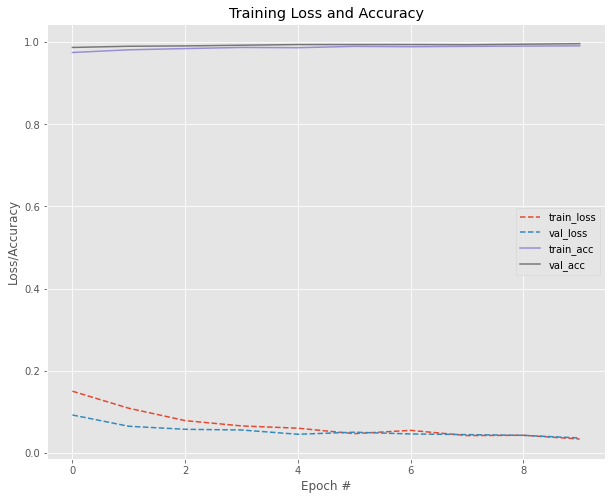

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 10), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 10), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 10), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 10), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [ ]:
images, labels = tuple(zip(*test_dataset))
images = np.concatenate(images,axis=0)
labels = np.concatenate(labels,axis=0)

In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(images, batch_size=32)
print(classification_report(tf.argmax(labels, axis=1),
                            tf.argmax(predictions, axis=1),
                            target_names=class_names))

[INFO] evaluating network...
18/18 [==============================] - 3s 163ms/step
              precision    recall  f1-score   support

 Garbage Bag       0.99      0.99      0.99       198
   Paper Bag       0.99      0.99      0.99       187
 Plastic Bag       0.99      0.98      0.99       191

    accuracy                           0.99       576
   macro avg       0.99      0.99      0.99       576
weighted avg       0.99      0.99      0.99       576



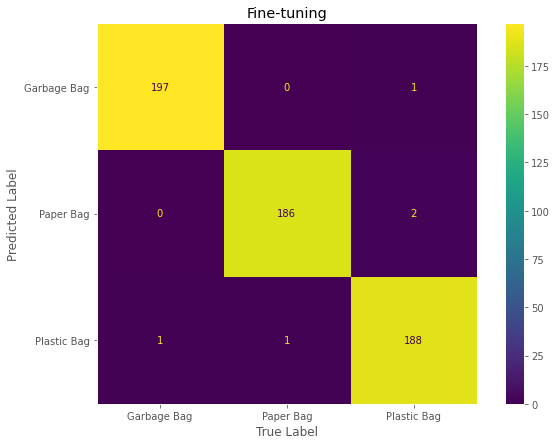

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(10,7))
ConfusionMatrixDisplay(confusion_matrix(tf.argmax(predictions, axis=1),
                                        tf.argmax(labels, axis=1)),
                       display_labels=class_names).plot(values_format=".0f",ax=ax)
ax.set_title("Fine-tuning")
ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

01-12-2022 23:51:25 Uploading figures


In [ ]:
# Evaluation Metrics
logger.info("Validation Evaluation metrics")
fbeta = fbeta_score(labels.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')
precision = precision_score(labels.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
recall = recall_score(labels.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')
acc = accuracy_score(labels.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Validation Accuracy: {}".format(acc))
logger.info("Validation Precision: {}".format(precision))
logger.info("Validation Recall: {}".format(recall))
logger.info("Validation F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta
# number of parameters
run.summary["Count_Params"] = model.count_params()

01-12-2022 23:51:25 Validation Evaluation metrics
01-12-2022 23:51:25 Validation Accuracy: 0.9913194444444444
01-12-2022 23:51:25 Validation Precision: 0.9913196388577828
01-12-2022 23:51:25 Validation Recall: 0.9913194444444444
01-12-2022 23:51:25 Validation F1: 0.9913149970836979


In [ ]:
run.finish()

Acc,0.99132
Count_Params,21138243
F1,0.99131
Precision,0.99132
Recall,0.99132
